In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils import resample

In [3]:
stock_tickers = {
    'Ferrari': 'RACE',          # Ferrari N.V. (NYSE)
    'Mercedes': 'MBGAF',        # Mercedes-Benz Group AG (OTC)
    'Aston Martin': 'AML.L',    # Aston Martin Lagonda (London Stock Exchange)
    'Alpine': 'RNSDF',          # Renault (OTC)
}

# Map constructor names in the dataset to standard names
constructor_mapping = {
    'Ferrari': 'Ferrari',
    'Mercedes': 'Mercedes',
    'McLaren': 'McLaren',
    'Red Bull': 'Red Bull',
    'Alpine F1 Team': 'Alpine',
    'Aston Martin': 'Aston Martin',
    'Williams': 'Williams',
    'Alfa Romeo': 'Alfa Romeo',
    'AlphaTauri': 'AlphaTauri',
    'Haas F1 Team': 'Haas',
    'Racing Bulls': 'VCARB'
}
start_year = 2021  # Ferrari IPO was in October 2015
end_year = 2025

In [4]:
data_path = "Data"  # Path to the Kaggle dataset
"""
Load F1 data from the Kaggle dataset

Parameters:
data_path - Path to the Kaggle dataset

Returns:
Dictionary with loaded dataframes
"""
print("Loading F1 data from Kaggle dataset...")
try:
    # Load main dataframes
    circuits = pd.read_csv(f"{data_path}/circuits.csv")
    constructor_results = pd.read_csv(f"{data_path}/constructor_results.csv")
    constructor_standings = pd.read_csv(f"{data_path}/constructor_standings.csv")
    constructors = pd.read_csv(f"{data_path}/constructors.csv")
    drivers = pd.read_csv(f"{data_path}/drivers.csv")
    races = pd.read_csv(f"{data_path}/races.csv")
    results = pd.read_csv(f"{data_path}/results.csv")
    
    print(f"Loaded data successfully:")
    print(f"- {len(races)} races from {races['year'].min()} to {races['year'].max()}")
    print(f"- {len(constructors)} constructors")
    print(f"- {len(drivers)} drivers")
    
    f1_data =  {
        'circuits': circuits,
        'constructor_results': constructor_results,
        'constructor_standings': constructor_standings,
        'constructors': constructors,
        'drivers': drivers,
        'races': races,
        'results': results
    }
except Exception as e:
    print(f"Error loading data: {str(e)}")

Loading F1 data from Kaggle dataset...
Loaded data successfully:
- 1125 races from 1950 to 2024
- 212 constructors
- 861 drivers


In [5]:
def get_stock_data(ticker, start_date, end_date):
    """
    Retrieve historical stock data for a given ticker
    
    Parameters:
    ticker - Stock ticker symbol
    start_date - Start date for data retrieval
    end_date - End date for data retrieval
    
    Returns:
    DataFrame with stock price data
    """
    if ticker is None:
        return None
    
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            print(f"No data found for ticker {ticker}")
            return None
        
        print(f"Successfully downloaded stock data for {ticker} ({len(stock_data)} trading days)")
        return stock_data
    except Exception as e:
        print(f"Error retrieving stock data for {ticker}: {str(e)}")
        return None
start_date = f"2017-01-01"
end_date = f"2024-12-31"
get_stock_data("WGF1.DE", start_date, end_date).describe()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Successfully downloaded stock data for WGF1.DE (2033 trading days)


Price,Close,High,Low,Open,Volume
Ticker,WGF1.DE,WGF1.DE,WGF1.DE,WGF1.DE,WGF1.DE
count,2033.000000,2033.000000,2033.000000,2033.000000,2033.000000
mean,12.876473,12.898753,12.846752,12.876621,108.689621
std,2.989941,3.002214,2.966907,2.984680,413.082909
min,9.750000,10.100000,9.700000,9.750000,0.000000
25%,10.500000,10.500000,10.500000,10.500000,0.000000
50%,10.500000,10.500000,10.500000,10.500000,0.000000
75%,15.100000,15.200000,15.100000,15.200000,0.000000
max,19.200001,19.330000,19.200001,19.200001,6032.000000


In [6]:
stock_data = get_stock_data("RACE", start_date, end_date)

[*********************100%***********************]  1 of 1 completed

Successfully downloaded stock data for RACE (2011 trading days)


In [7]:
def extract_constructor_performance(f1_data, constructor_name, year_from, year_to):
    """
    Extract performance data for a specific constructor from F1 dataset
    
    Parameters:
    f1_data - Dictionary with F1 dataframes
    constructor_name - Name of the constructor to extract data for
    year_from - Starting year for data extraction
    year_to - Ending year for data extraction
    
    Returns:
    DataFrame with constructor performance data
    """
    races = f1_data['races']
    constructors = f1_data['constructors']
    constructor_standings = f1_data['constructor_standings']
    results = f1_data['results']
    
    # Filter races within the time range
    races_filtered = races[(races['year'] >= year_from) & (races['year'] <= year_to)]
    
    # Get constructor ID
    constructor_matches = constructors[constructors['name'].str.contains(constructor_name, case=False)]
    if constructor_matches.empty:
        print(f"Constructor '{constructor_name}' not found in the dataset")
        return None
    
    constructor_id = constructor_matches['constructorId'].values[0]
    print(f"Found constructor ID {constructor_id} for {constructor_name}")
    
    # Filter constructor standings for this constructor
    standings = constructor_standings[constructor_standings['constructorId'] == constructor_id]
    
    # Join with races to get dates
    performance_data = pd.merge(
        standings, 
        races_filtered[['raceId', 'date', 'year', 'round', 'name']], 
        on='raceId'
    )
    
    # Get additional race results for this constructor
    constructor_race_results = results[results['constructorId'] == constructor_id]
    
    # Get race results with additional details
    race_results = pd.merge(
        constructor_race_results,
        races_filtered[['raceId', 'date', 'year', 'round', 'name']],
        on='raceId'
    )
    
    # Sort by date
    performance_data = performance_data.sort_values('date')
    performance_data['date'] = pd.to_datetime(performance_data['date'])
    
    race_results = race_results.sort_values('date')
    race_results['date'] = pd.to_datetime(race_results['date'])
    
    print(f"Extracted {len(performance_data)} races for {constructor_name} from {year_from} to {year_to}")
    
    return {
        'standings': performance_data,
        'results': race_results
    }
extract_constructor_performance(f1_data, "Ferrari", start_year, end_year)["standings"].head()


Found constructor ID 6 for Ferrari
Extracted 90 races for Ferrari from 2021 to 2025


,constructorStandingsId,raceId,constructorId,points,position,positionText,wins,date,year,round,name
1,27676,1052,6,12.0,4,4,0,2021-03-28,2021,1,Bahrain Grand Prix
2,27706,1053,6,34.0,4,4,0,2021-04-18,2021,2,Emilia Romagna Grand Prix
3,27716,1054,6,42.0,4,4,0,2021-05-02,2021,3,Portuguese Grand Prix
4,27726,1055,6,60.0,4,4,0,2021-05-09,2021,4,Spanish Grand Prix
5,27736,1056,6,78.0,4,4,0,2021-05-23,2021,5,Monaco Grand Prix


In [8]:
performance_data = extract_constructor_performance(f1_data, "Ferrari", start_year, end_year)

Found constructor ID 6 for Ferrari
Extracted 90 races for Ferrari from 2021 to 2025


In [9]:
def align_f1_with_stock(performance_data, stock_data, team_name):
    """
    Align F1 race results with stock data - Fixed version that handles Series properly
    
    Parameters:
    performance_data - Dictionary with team performance data
    stock_data - Stock price data
    team_name - Name of the team for identification
    
    Returns:
    DataFrame with aligned F1 and stock data
    """
    print(f"Aligning F1 results with stock data for {team_name}...")
    
    if stock_data is None:
        print(f"No stock data available for {team_name}")
        return None
    
    # Use constructor standings data
    f1_data = performance_data['standings'].copy()
    
    # Convert date columns to datetime
    f1_data['date'] = pd.to_datetime(f1_data['date'])
    stock_data.index = pd.to_datetime(stock_data.index)
    
    # Create a dataframe to store aligned data
    aligned_data = []
    
    for _, race in f1_data.iterrows():
        race_date = race['date']
        
        try:
            # Get the next 5 trading days after the race
            next_trading_days = stock_data.loc[race_date:race_date + timedelta(days=10)].head(2)
            
            # Get the previous 5 trading days before the race
            prev_trading_days = stock_data.loc[race_date - timedelta(days=10):race_date].tail(2)
            
            if not next_trading_days.empty and not prev_trading_days.empty:
                # Calculate stock performance metrics
                pre_race_price = prev_trading_days['Close'].mean()
                post_race_price = next_trading_days['Close'].mean()
                price_change = (post_race_price - pre_race_price) / pre_race_price * 100
                
                # Create a row with race and stock data
                row = {
                    'race_id': race['raceId'],
                    'race_name': race['name'],
                    'race_date': race_date,
                    'year': race['year'],
                    'round': race['round'],
                    'points': race['points'],
                    'position': race['position'],
                    'pre_race_price': pre_race_price,
                    'post_race_price': post_race_price,
                    'price_change_pct': price_change,
                    'wins': race['wins'],
                    'team': team_name,
                }
                aligned_data.append(row)
        except Exception as e:
            print(f"Error processing race {race['name']} {race['year']}: {str(e)}")
            continue
    
    if not aligned_data:
        print(f"No aligned data available for {team_name}")
        return None
    
    return pd.DataFrame(aligned_data)
aligned_data = align_f1_with_stock(performance_data, stock_data, "Ferrari")

Aligning F1 results with stock data for Ferrari...


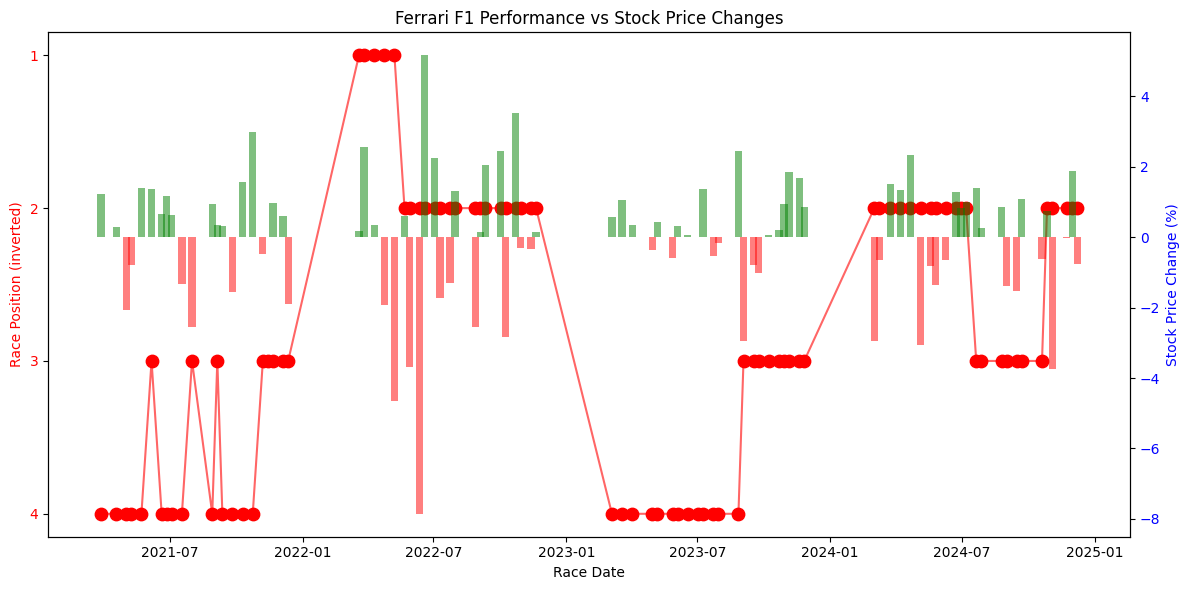

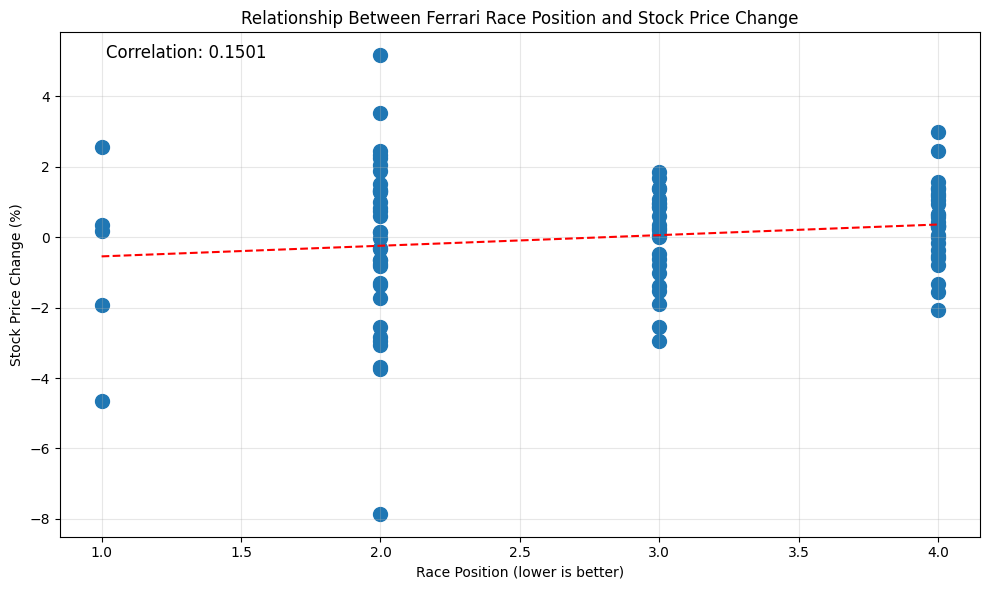

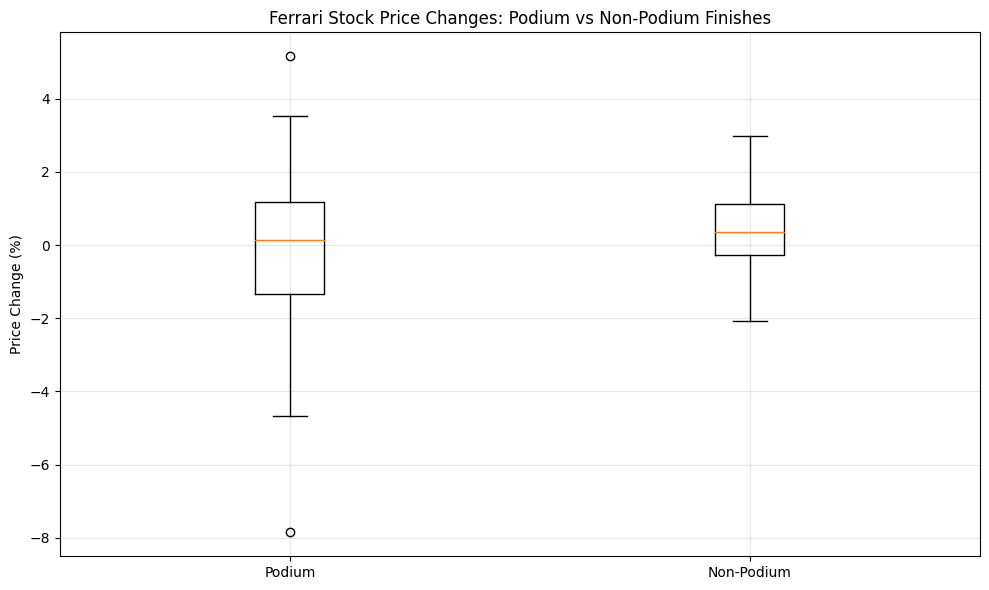

In [10]:
def visualize_performance_vs_stock(aligned_data, constructor_name):
    """
    Create visualizations of F1 performance vs stock price changes
    Ultra-robust version avoiding any Series operations
    
    Parameters:
    aligned_data - DataFrame with aligned F1 and stock data
    constructor_name - Constructor name for the chart title
    
    Returns:
    None (displays plots)
    """
    if aligned_data is None or len(aligned_data) == 0:
        print(f"No data to visualize for {constructor_name}")
        return
    
    
    try:
        dates = [d for d in aligned_data['race_date']]
        # print("Dates:",dates)
        positions = [float(p) if isinstance(p, (int, float)) else float('nan') for p in aligned_data['position']]
        # print("Positons:",positions)
        # print(aligned_data['price_change_pct'])
        price_changes = [float(pc.iloc[0]) if isinstance(pc, pd.Series) and not pc.empty else float('nan') for pc in aligned_data['price_change_pct']]
        # print("Price changes:",price_changes)
        years = [int(y) if isinstance(y, (int, float)) else 0 for y in aligned_data['year']]
        rounds = [int(r) if isinstance(r, (int, float)) else 0 for r in aligned_data['round']]
    except Exception as e:
        print(f"Error converting data: {e}")
        # Print for debugging
        print("Column names:", aligned_data.columns.tolist())
        print("Data types:", {col: aligned_data[col].dtype for col in aligned_data.columns})
        return
    
    # Create figure with two y-axes for time series plot
    try:
        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()
        
        # Plot positions (inverted so better positions are higher)
        ax1.scatter(dates, [-p for p in positions], color='red', s=80)
        ax1.plot(dates, [-p for p in positions], color='red', alpha=0.6)
        
        ax1.set_xlabel('Race Date')
        ax1.set_ylabel('Race Position (inverted)', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        
        # Set y-ticks for positions
        max_pos = max([p for p in positions if not np.isnan(p)], default=10)
        ax1.set_yticks([-i for i in range(1, int(max_pos) + 1)])
        ax1.set_yticklabels([i for i in range(1, int(max_pos) + 1)])
        
        # Create second y-axis
        ax2 = ax1.twinx()
        
        # Plot bars for price changes with manually assigned colors
        for i, (date, change) in enumerate(zip(dates, price_changes)):
            if np.isnan(change):
                continue
            color = 'green' if change >= 0 else 'red'
            ax2.bar(date, change, color=color, alpha=0.5, width=10)  # width in days
        
        ax2.set_ylabel('Stock Price Change (%)', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        plt.title(f'{constructor_name} F1 Performance vs Stock Price Changes')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating time series plot: {e}")
    
    # Create scatter plot
    try:
        # Filter out NaN values
        valid_data = [(p, c) for p, c in zip(positions, price_changes) if not np.isnan(p) and not np.isnan(c)]
        if not valid_data:
            print("No valid data points for scatter plot")
            return
            
        valid_positions, valid_changes = zip(*valid_data)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(valid_positions, valid_changes, s=100)
        
        # Calculate trend line if we have enough points
        if len(valid_positions) > 1:
            z = np.polyfit(valid_positions, valid_changes, 1)
            p = np.poly1d(z)
            x_range = np.linspace(min(valid_positions), max(valid_positions), 100)
            plt.plot(x_range, p(x_range), "r--")
            
            # Calculate correlation
            correlation = np.corrcoef(valid_positions, valid_changes)[0, 1]
            plt.annotate(f'Correlation: {correlation:.4f}', 
                        xy=(0.05, 0.95), xycoords='axes fraction', 
                        fontsize=12)
        
        plt.title(f'Relationship Between {constructor_name} Race Position and Stock Price Change')
        plt.xlabel('Race Position (lower is better)')
        plt.ylabel('Stock Price Change (%)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating scatter plot: {e}")
    
    # Create boxplot for podium vs non-podium
    try:
        podium_changes = []
        non_podium_changes = []
        
        for pos, change in zip(positions, price_changes):
            if np.isnan(pos) or np.isnan(change):
                continue
            if pos <= 3:
                podium_changes.append(change)
            else:
                non_podium_changes.append(change)
        
        if podium_changes and non_podium_changes:
            plt.figure(figsize=(10, 6))
            
            # Create data for boxplot
            box_data = [podium_changes, non_podium_changes]
            plt.boxplot(box_data, labels=['Podium', 'Non-Podium'])
            
            plt.title(f'{constructor_name} Stock Price Changes: Podium vs Non-Podium Finishes')
            plt.ylabel('Price Change (%)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough data for podium comparison boxplot")
    except Exception as e:
        print(f"Error creating boxplot: {e}")
visualize_performance_vs_stock(aligned_data, "Ferrari")

In [11]:
def analyze_performance_stock_relationship(aligned_data, constructor_name):
    """
    Analyze statistical relationship between F1 performance and stock price changes
    Ultra-robust version avoiding Series operations
    
    Parameters:
    aligned_data - DataFrame with aligned F1 and stock data
    constructor_name - Constructor name for analysis identification
    
    Returns:
    Dictionary with analysis results
    """
    print(f"\n===== {constructor_name} F1 Performance and Stock Analysis =====")
    
    if aligned_data is None or len(aligned_data) == 0:
        print(f"No data to analyze for {constructor_name}")
        return None
    
    try:
        # Convert DataFrame columns to Python lists for robustness
        positions = []
        price_changes = []
        
        # Handle each row individually to avoid Series operations
        for _, row in aligned_data.iterrows():
            try:
                pos = float(row['position'])
                change = float(row['price_change_pct'])
                
                # Skip if either value is NaN
                if not np.isnan(pos) and not np.isnan(change):
                    positions.append(pos)
                    price_changes.append(change)
            except (ValueError, TypeError):
                continue  # Skip rows with conversion errors
        
        if not positions or not price_changes:
            print(f"No valid numeric data to analyze for {constructor_name}")
            return None
            
        # Calculate correlation using numpy to avoid pandas Series operations
        correlation = np.corrcoef(positions, price_changes)[0, 1]
        print(f"Correlation between position and stock change: {correlation:.4f}")
        
        # Separate podium and non-podium results
        podium_changes = [change for pos, change in zip(positions, price_changes) if pos <= 3]
        non_podium_changes = [change for pos, change in zip(positions, price_changes) if pos > 3]
        
        # Calculate average changes
        avg_change_podium = np.mean(podium_changes) if podium_changes else None
        avg_change_non_podium = np.mean(non_podium_changes) if non_podium_changes else None
        
        if avg_change_podium is not None:
            print(f"Average stock change after podium finishes: {avg_change_podium:.2f}%")
        if avg_change_non_podium is not None:
            print(f"Average stock change after non-podium finishes: {avg_change_non_podium:.2f}%")
        
        # Separate win and non-win results
        victory_changes = [change for pos, change in zip(positions, price_changes) if pos == 1]
        non_victory_changes = [change for pos, change in zip(positions, price_changes) if pos != 1]
        
        # Calculate average changes for wins/non-wins
        avg_change_victory = np.mean(victory_changes) if victory_changes else None
        avg_change_non_victory = np.mean(non_victory_changes) if non_victory_changes else None
        
        if avg_change_victory is not None:
            print(f"Average stock change after victories: {avg_change_victory:.2f}%")
        if avg_change_non_victory is not None:
            print(f"Average stock change after non-victories: {avg_change_non_victory:.2f}%")
        
        t_stat = None
        p_value = None
        significant_difference = False
        
        if len(podium_changes) > 1 and len(non_podium_changes) > 1:
            from scipy.stats import ttest_ind
            try:
                t_stat, p_value = ttest_ind(
                    podium_changes, 
                    non_podium_changes,
                    equal_var=False
                )
                significant_difference = p_value < 0.05
                
                print(f"T-test results: t={t_stat:.4f}, p={p_value:.4f}")
                print(f"Statistically significant difference: {significant_difference}")
            except Exception as e:
                print(f"Error performing t-test: {e}")
        
        # Return results as dictionary
        results = {
            'constructor': constructor_name,
            'position_correlation': correlation,
            'avg_change_podium': avg_change_podium,
            'avg_change_non_podium': avg_change_non_podium,
            'avg_change_victory': avg_change_victory,
            'avg_change_non_victory': avg_change_non_victory,
            't_statistic': t_stat,
            'p_value': p_value,
            'significant_difference': significant_difference,
            'sample_size': len(positions)
        }
        
        return results
        
    except Exception as e:
        print(f"Error analyzing {constructor_name} data: {e}")
        # Print column info for debugging
        print("DataFrame columns:", aligned_data.columns.tolist())
        print("Column types:", {col: str(aligned_data[col].dtype) for col in aligned_data.columns})
        return None
analyze_performance_stock_relationship(aligned_data, "Ferrari")


===== Ferrari F1 Performance and Stock Analysis =====
Correlation between position and stock change: 0.1501
Average stock change after podium finishes: -0.16%
Average stock change after non-podium finishes: 0.39%
Average stock change after victories: -0.70%
Average stock change after non-victories: 0.04%
T-test results: t=-1.5976, p=0.1139
Statistically significant difference: False


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])


{'constructor': 'Ferrari',
 'position_correlation': 0.15014000520363155,
 'avg_change_podium': -0.16320760845425,
 'avg_change_non_podium': 0.38636535127887095,
 'avg_change_victory': -0.6977418939251593,
 'avg_change_non_victory': 0.04280581907691253,
 't_statistic': -1.597563333166349,
 'p_value': 0.11393227597827787,
 'significant_difference': False,
 'sample_size': 90}

In [12]:
def build_stock_direction_model(aligned_data, constructor_name):
    print(f"\nBuilding ensemble classification model for {constructor_name} stock direction...")

    if aligned_data is None or len(aligned_data) < 10:
        print(f"Not enough data to build a model for {constructor_name}")
        return None

    # 1. Build clean feature-label dataset
    data_rows = []
    for _, row in aligned_data.iterrows():
        try:
            position = float(row['position'])
            points = float(row.get('points', 0.0))
            race_round = float(row.get('round', 0.0))
            price_change = float(row['price_change_pct'])

            if abs(price_change) > 10:
                continue

            label = 1 if price_change > 0 else 0

            data_rows.append({
                'position': position,
                'points': points,
                'round': race_round,
                'price_up': label
            })
        except:
            continue

    if len(data_rows) < 10:
        print("Not enough valid data after filtering.")
        return None

    df = pd.DataFrame(data_rows)

    # 2. Balance the classes
    class_0 = df[df['price_up'] == 0]
    class_1 = df[df['price_up'] == 1]
    if len(class_0) > 0 and len(class_1) > 0:
        majority = class_0 if len(class_0) > len(class_1) else class_1
        minority = class_1 if len(class_0) > len(class_1) else class_0
        minority_upsampled = resample(minority, 
                                      replace=True, 
                                      n_samples=len(majority), 
                                      random_state=42)
        df = pd.concat([majority, minority_upsampled])

    # 3. Prepare features
    features = ['position', 'points', 'round']
    X = df[features]
    y = df['price_up']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Define individual models
    logreg = LogisticRegression(class_weight='balanced', random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    # 5. Voting classifier
    ensemble = VotingClassifier(
        estimators=[
            ('logreg', logreg),
            ('rf', rf),
            ('gb', gb)
        ],
        voting='soft'  # use probabilities
    )

    ensemble.fit(X_train_scaled, y_train)
    y_pred = ensemble.predict(X_test_scaled)
    y_proba = ensemble.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    r2 = r2_score(y_test, y_proba)

    mae = mean_absolute_error(y_test, y_proba)
    mse = mean_squared_error(y_test, y_proba)

    


    print(f"\n===== Ensemble Model Results =====")
    print(f"Accuracy:   {acc:.4f}")
    print(f"F1 Score:   {f1:.4f}")
    print(f"ROC AUC:    {auc:.4f}")
    print(f"R2 Score:   {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Sample Size: {len(X_test)}")
    print(f"Sample Size: {len(df)} (balanced)")

    return {
        'model': ensemble,
        'scaler': scaler,
        'features': features
    }

build_stock_direction_model(aligned_data, "Ferrari")



Building ensemble classification model for Ferrari stock direction...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])



===== Ensemble Model Results =====
Accuracy:   0.4688
F1 Score:   0.5143
ROC AUC:    0.4549
R2 Score:   -0.2586
Mean Absolute Error (MAE): 0.5083
Mean Squared Error (MSE): 0.3134
Sample Size: 32
Sample Size: 106 (balanced)


{'model': VotingClassifier(estimators=[('logreg',
                               LogisticRegression(class_weight='balanced',
                                                  random_state=42)),
                              ('rf', RandomForestClassifier(random_state=42)),
                              ('gb',
                               GradientBoostingClassifier(random_state=42))],
                  voting='soft'),
 'scaler': StandardScaler(),
 'features': ['position', 'points', 'round']}


Processing Ferrari (['HPQ']) from 2023 to 2025
Getting stock data for ['HPQ']...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ['HPQ'] (578 trading days)
Extracting Ferrari performance data...
Found constructor ID 6 for Ferrari
Extracted 46 races for Ferrari from 2023 to 2025
Aligning F1 results with stock data for Ferrari...
Aligning F1 results with stock data for Ferrari...
Creating visualizations for Ferrari...


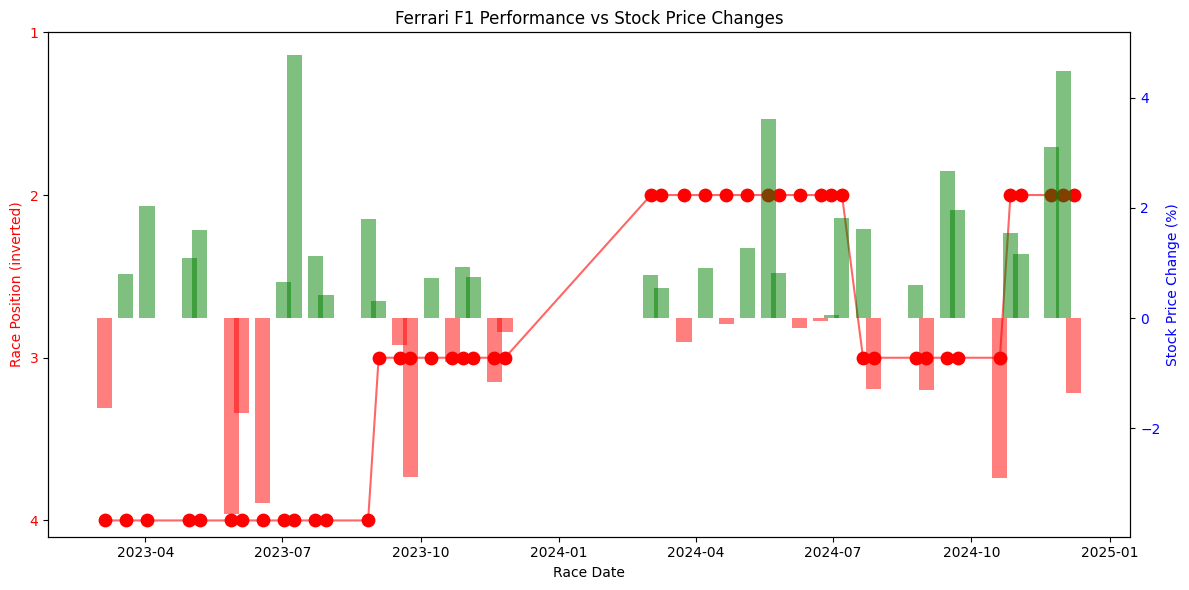

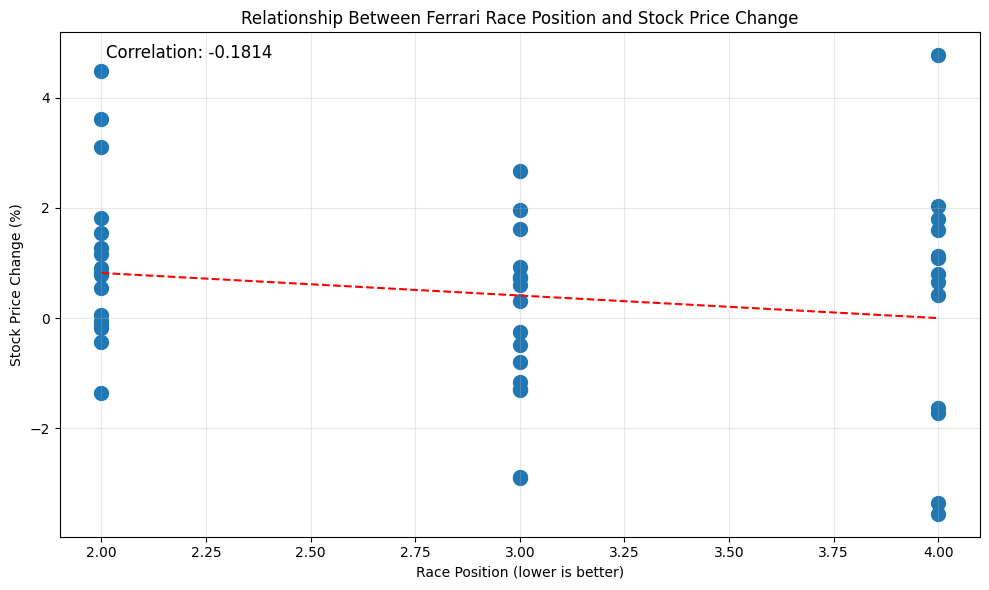

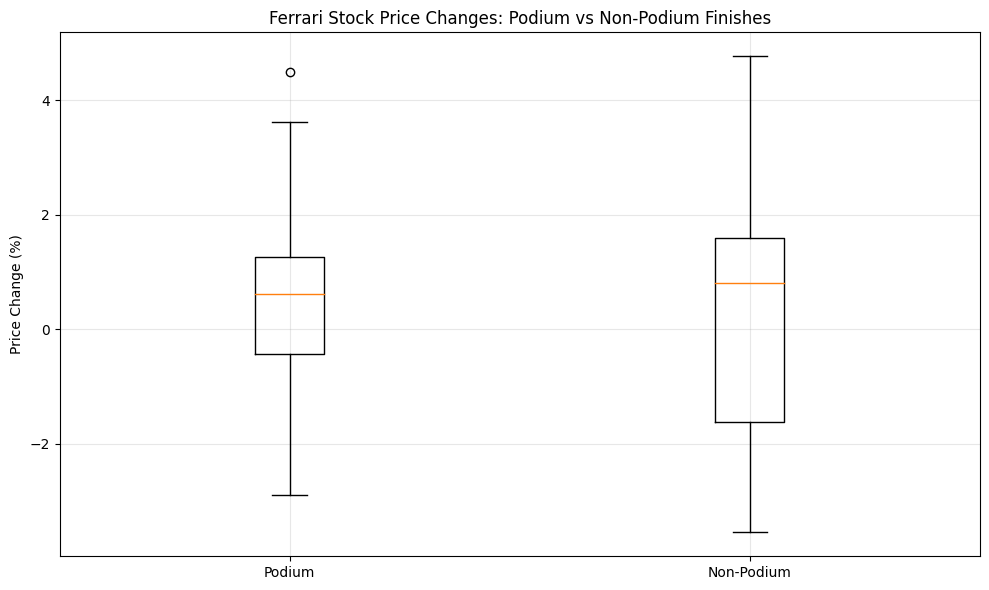


===== Ferrari F1 Performance and Stock Analysis =====
Correlation between position and stock change: -0.1814
Average stock change after podium finishes: 0.50%
Average stock change after non-podium finishes: 0.31%
Average stock change after non-victories: 0.45%
T-test results: t=0.2661, p=0.7934
Statistically significant difference: False

Building ensemble classification model for Ferrari stock direction...

===== Ensemble Model Results =====
Accuracy:   0.7222
F1 Score:   0.7368
ROC AUC:    0.6625
R2 Score:   -0.0113
Mean Absolute Error (MAE): 0.4200
Mean Squared Error (MSE): 0.2497
Sample Size: 18
Sample Size: 58 (balanced)

Processing Red Bull (['MC.PA']) from 2023 to 2025
Getting stock data for ['MC.PA']...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])
C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])
[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ['MC.PA'] (589 trading days)
Extracting Red Bull performance data...
Found constructor ID 9 for Red Bull
Extracted 46 races for Red Bull from 2023 to 2025
Aligning F1 results with stock data for Red Bull...
Aligning F1 results with stock data for Red Bull...
Creating visualizations for Red Bull...


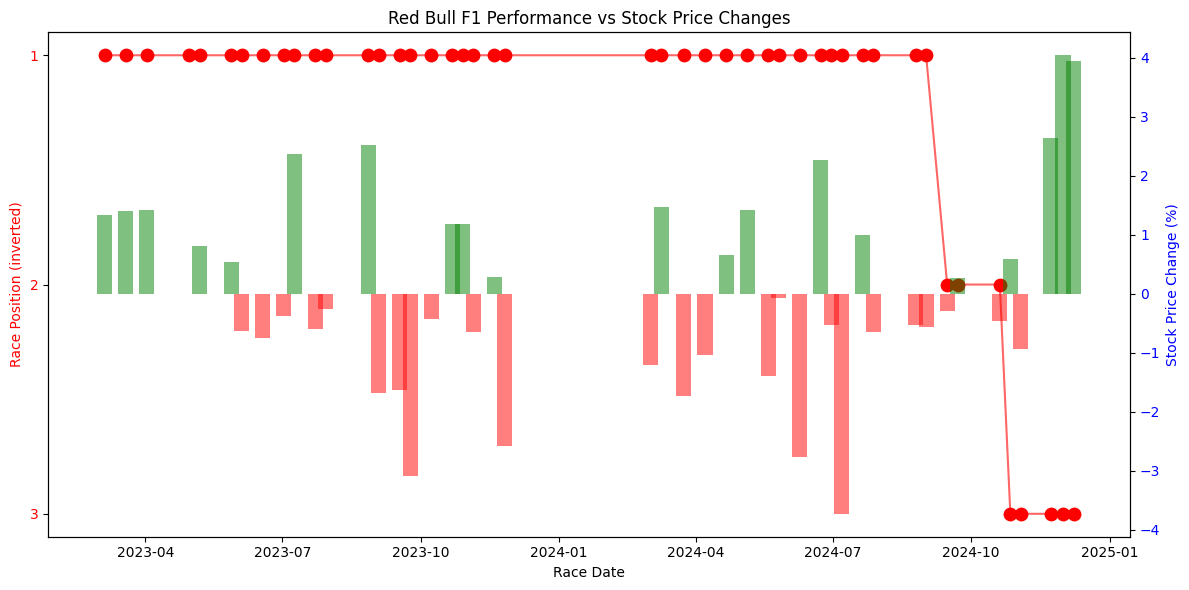

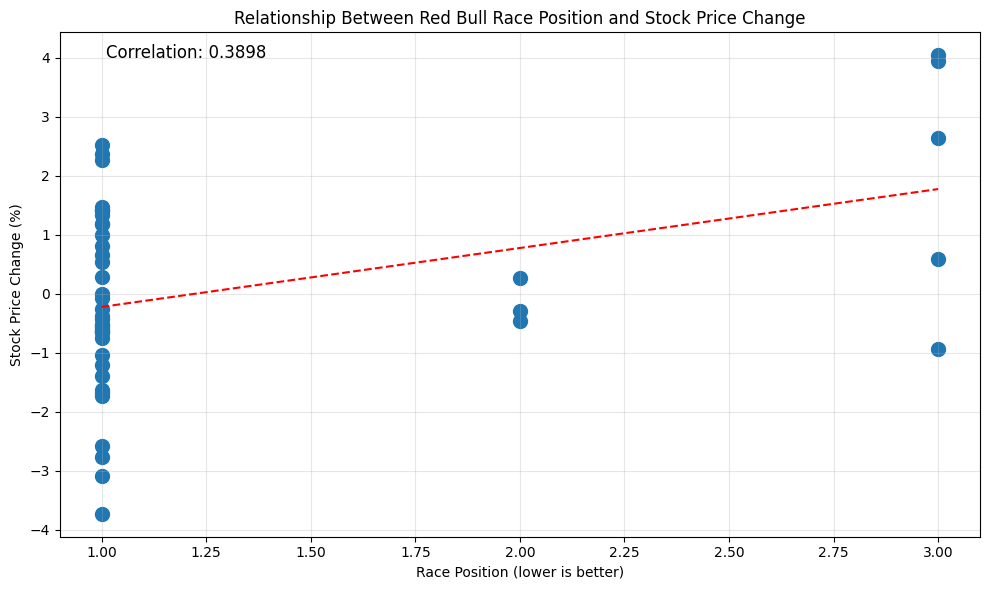

Not enough data for podium comparison boxplot

===== Red Bull F1 Performance and Stock Analysis =====
Correlation between position and stock change: 0.3898
Average stock change after podium finishes: 0.06%
Average stock change after victories: -0.19%
Average stock change after non-victories: 1.23%

Building ensemble classification model for Red Bull stock direction...

===== Ensemble Model Results =====
Accuracy:   0.5625
F1 Score:   0.6316
ROC AUC:    0.6190
R2 Score:   -0.1864
Mean Absolute Error (MAE): 0.4637
Mean Squared Error (MSE): 0.2920
Sample Size: 16
Sample Size: 52 (balanced)

Processing Mercedes (['TMV.DE']) from 2023 to 2025
Getting stock data for ['TMV.DE']...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])
C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])
[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ['TMV.DE'] (587 trading days)
Extracting Mercedes performance data...
Found constructor ID 131 for Mercedes
Extracted 46 races for Mercedes from 2023 to 2025
Aligning F1 results with stock data for Mercedes...
Aligning F1 results with stock data for Mercedes...
Creating visualizations for Mercedes...


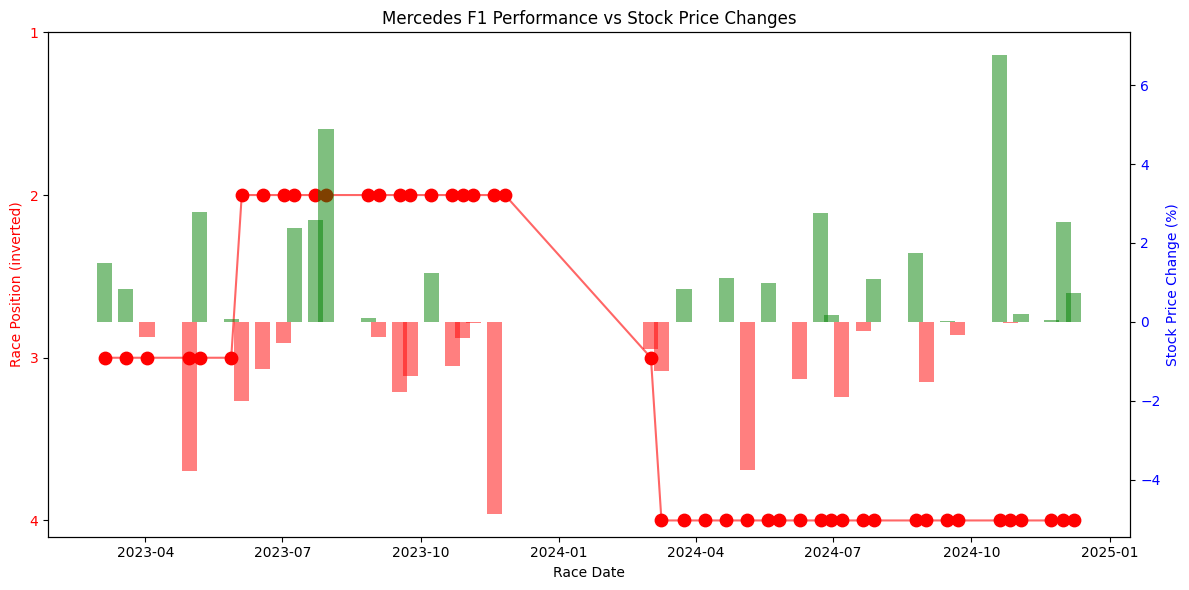

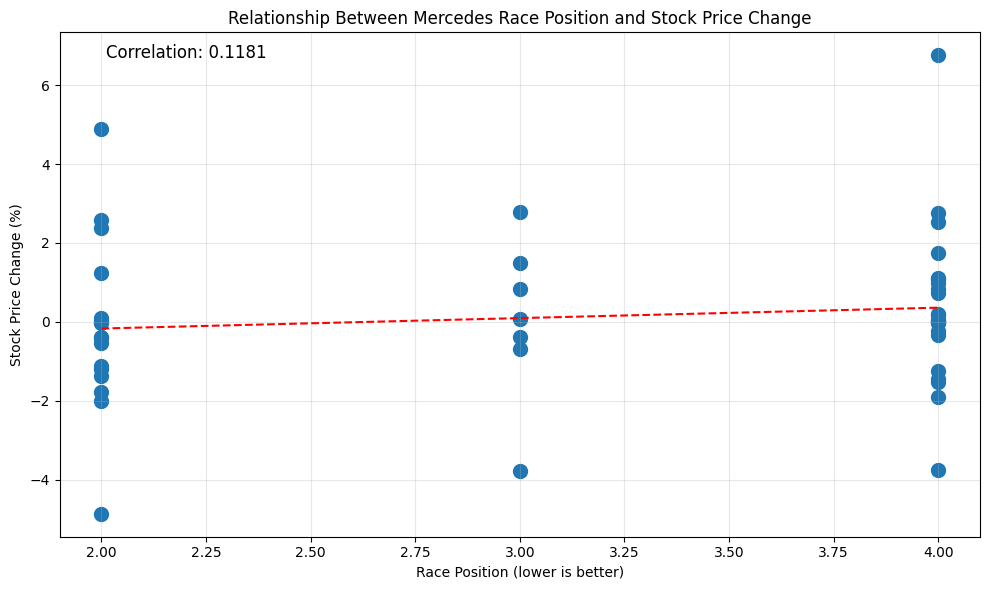

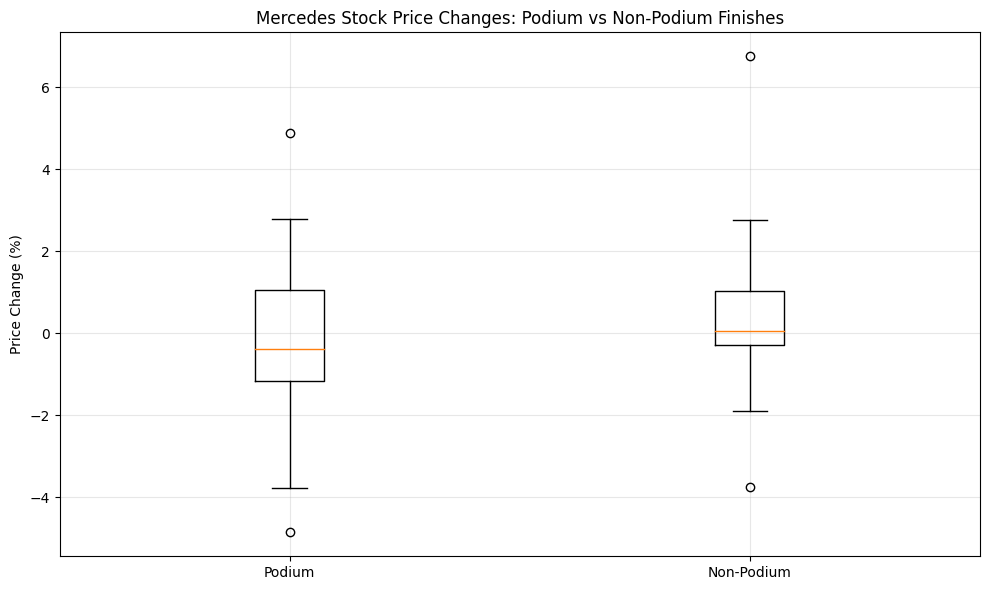


===== Mercedes F1 Performance and Stock Analysis =====
Correlation between position and stock change: 0.1181
Average stock change after podium finishes: -0.10%
Average stock change after non-podium finishes: 0.37%
Average stock change after non-victories: 0.14%
T-test results: t=-0.7604, p=0.4511
Statistically significant difference: False

Building ensemble classification model for Mercedes stock direction...

===== Ensemble Model Results =====
Accuracy:   0.7143
F1 Score:   0.6667
ROC AUC:    0.7708
R2 Score:   0.1013
Mean Absolute Error (MAE): 0.3707
Mean Squared Error (MSE): 0.2201
Sample Size: 14
Sample Size: 46 (balanced)

Processing Aston Martin (['CTSH']) from 2023 to 2025
Getting stock data for ['CTSH']...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])
C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])
[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ['CTSH'] (578 trading days)
Extracting Aston Martin performance data...
Found constructor ID 117 for Aston Martin
Extracted 46 races for Aston Martin from 2023 to 2025
Aligning F1 results with stock data for Aston Martin...
Aligning F1 results with stock data for Aston Martin...
Creating visualizations for Aston Martin...


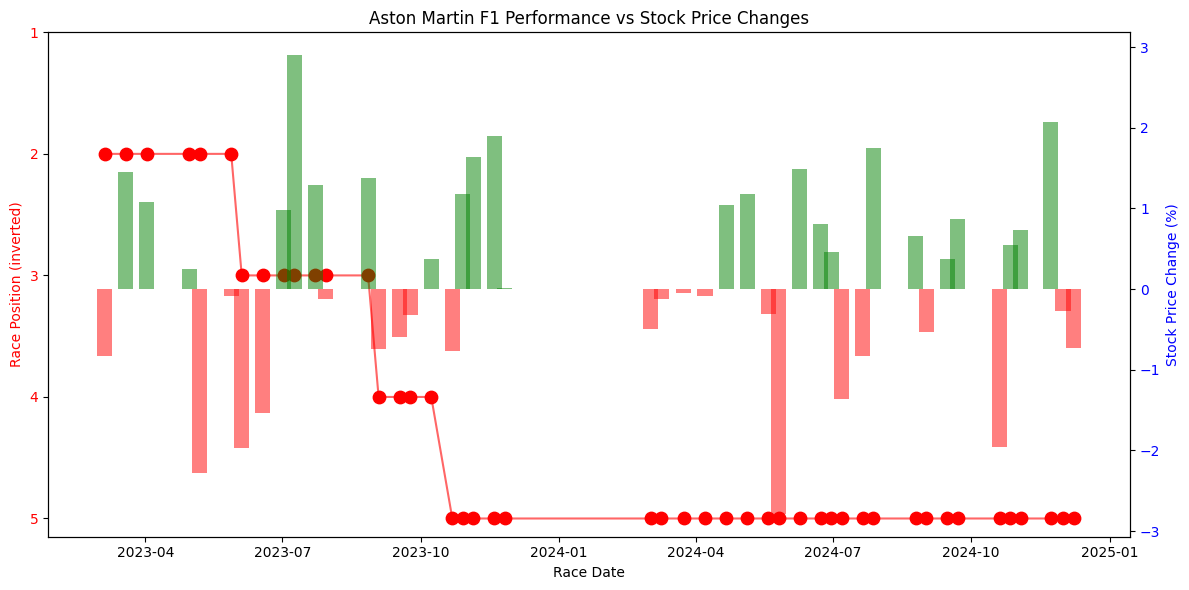

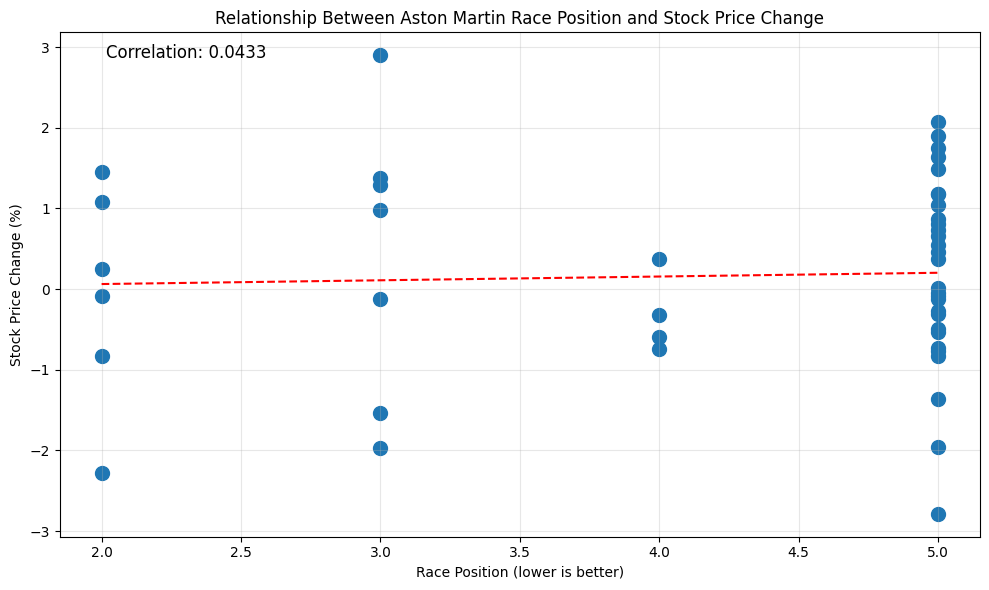

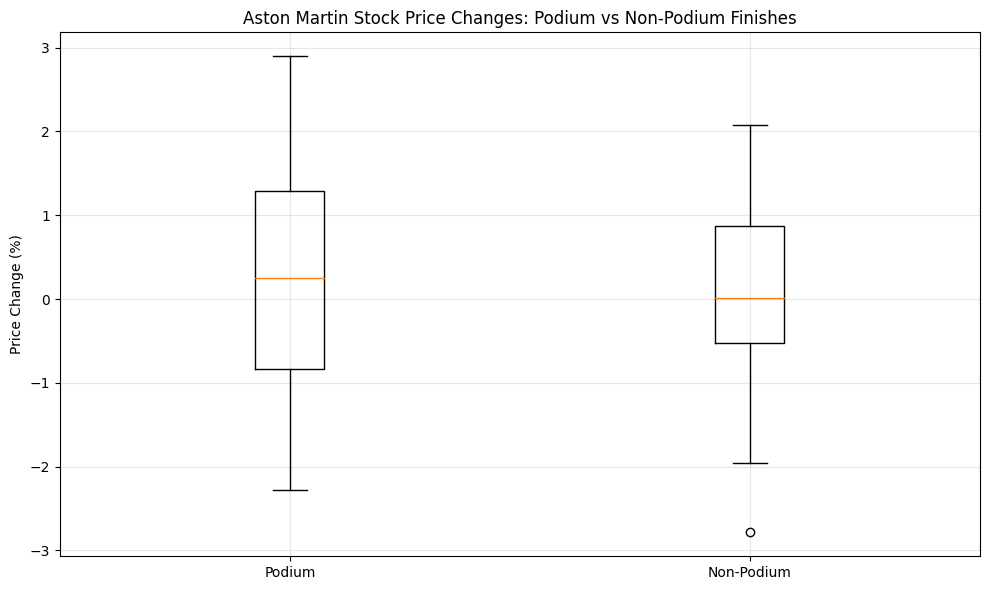


===== Aston Martin F1 Performance and Stock Analysis =====
Correlation between position and stock change: 0.0433
Average stock change after podium finishes: 0.19%
Average stock change after non-podium finishes: 0.16%
Average stock change after non-victories: 0.17%
T-test results: t=0.0770, p=0.9395
Statistically significant difference: False

Building ensemble classification model for Aston Martin stock direction...

===== Ensemble Model Results =====
Accuracy:   0.7333
F1 Score:   0.6667
ROC AUC:    0.7407
R2 Score:   0.1409
Mean Absolute Error (MAE): 0.3861
Mean Squared Error (MSE): 0.2062
Sample Size: 15
Sample Size: 48 (balanced)

Processing Alpine (['MSFT']) from 2023 to 2025
Getting stock data for ['MSFT']...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])
C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])
[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ['MSFT'] (578 trading days)
Extracting Alpine performance data...
Found constructor ID 214 for Alpine
Extracted 46 races for Alpine from 2023 to 2025
Aligning F1 results with stock data for Alpine...
Aligning F1 results with stock data for Alpine...
Creating visualizations for Alpine...


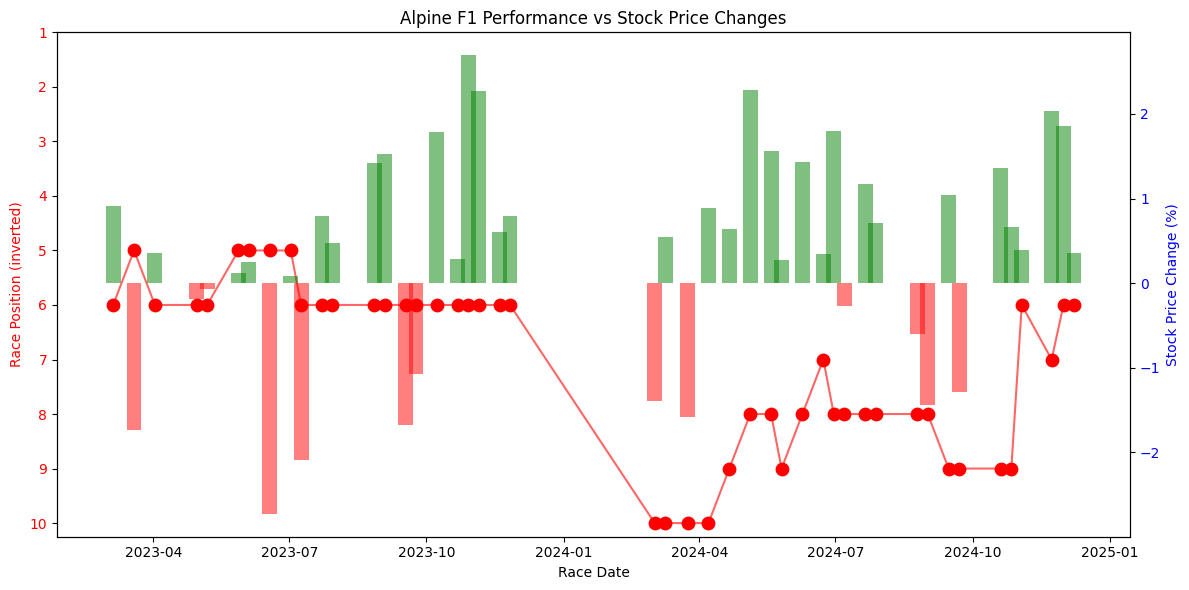

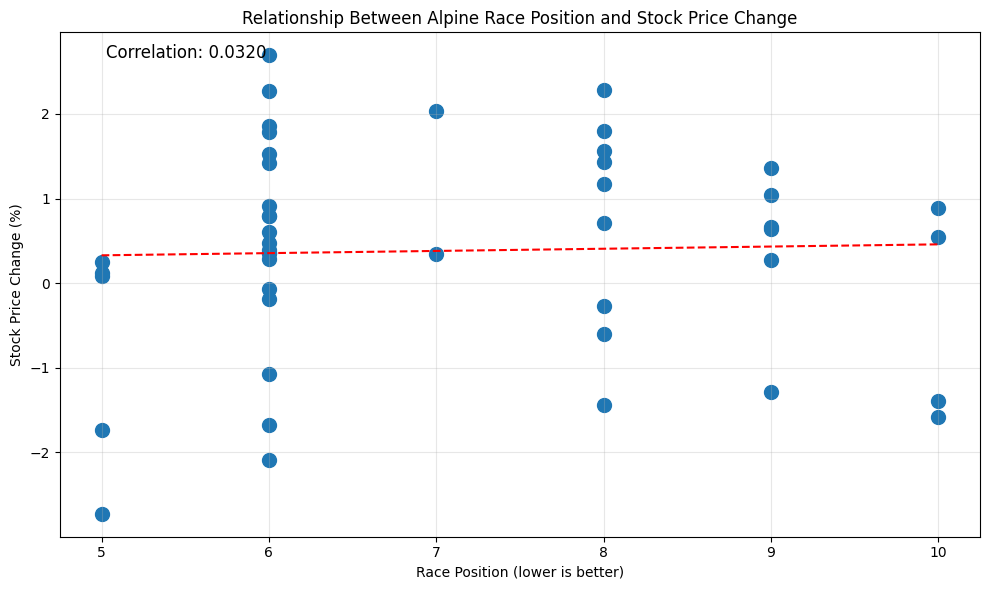

Not enough data for podium comparison boxplot

===== Alpine F1 Performance and Stock Analysis =====
Correlation between position and stock change: 0.0320
Average stock change after non-podium finishes: 0.38%
Average stock change after non-victories: 0.38%

Building ensemble classification model for Alpine stock direction...

===== Ensemble Model Results =====
Accuracy:   0.6500
F1 Score:   0.6316
ROC AUC:    0.7980
R2 Score:   0.1453
Mean Absolute Error (MAE): 0.3945
Mean Squared Error (MSE): 0.2115
Sample Size: 20
Sample Size: 66 (balanced)

Processing Williams (['TEAM']) from 2023 to 2025
Getting stock data for ['TEAM']...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])
C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])
[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ['TEAM'] (578 trading days)
Extracting Williams performance data...
Found constructor ID 3 for Williams
Extracted 46 races for Williams from 2023 to 2025
Aligning F1 results with stock data for Williams...
Aligning F1 results with stock data for Williams...
Creating visualizations for Williams...


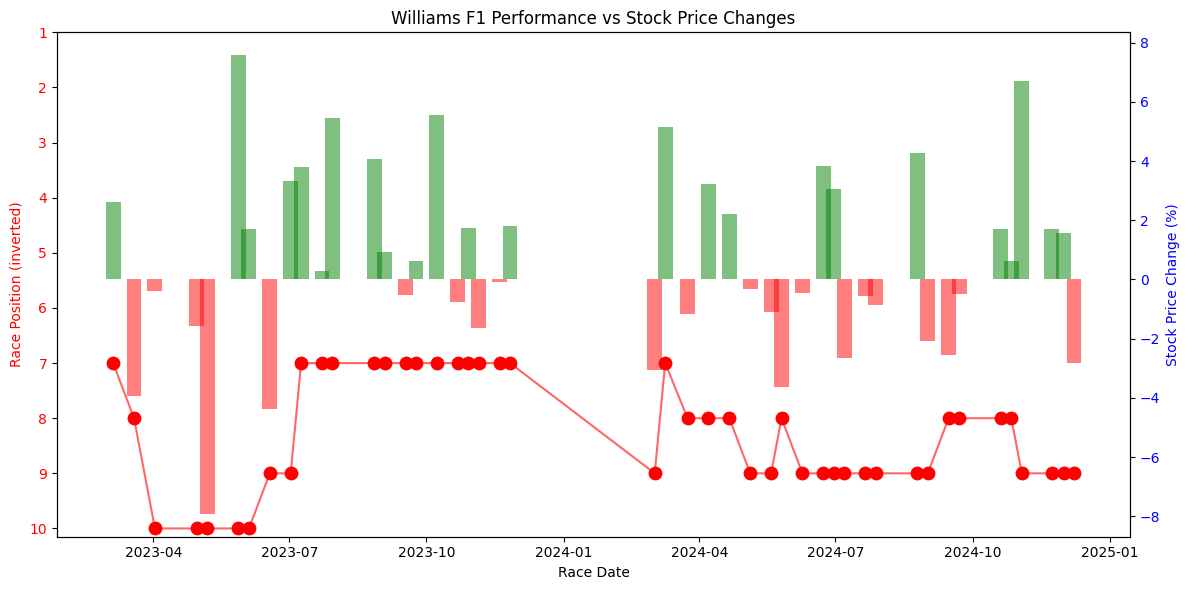

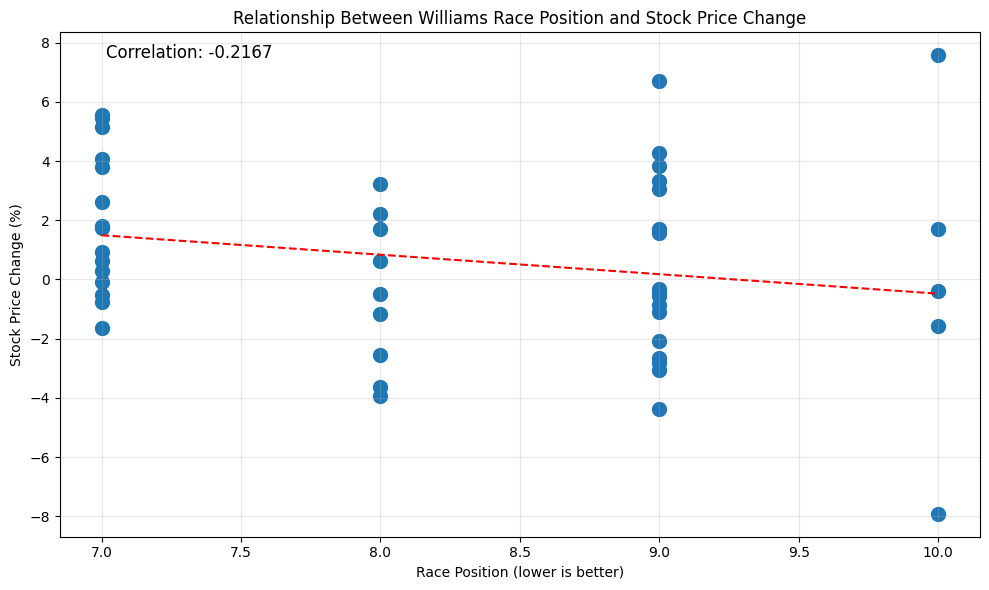

Not enough data for podium comparison boxplot

===== Williams F1 Performance and Stock Analysis =====
Correlation between position and stock change: -0.2167
Average stock change after non-podium finishes: 0.66%
Average stock change after non-victories: 0.66%

Building ensemble classification model for Williams stock direction...

===== Ensemble Model Results =====
Accuracy:   0.8000
F1 Score:   0.7273
ROC AUC:    0.8148
R2 Score:   0.3019
Mean Absolute Error (MAE): 0.3553
Mean Squared Error (MSE): 0.1675
Sample Size: 15
Sample Size: 48 (balanced)

Processing Visa RB (['SQ']) from 2023 to 2025
Getting stock data for ['SQ']...


C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\214620373.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  change = float(row['price_change_pct'])
C:\Users\abhir\AppData\Local\Temp\ipykernel_11044\1114884382.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float(row['price_change_pct'])
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')


No data found for ticker ['SQ']


In [13]:
start_year = 2023  # Ferrari IPO was in October 2015
end_year = 2025

# Define F1 teams with stock tickers to analyze
public_teams1 = {
  "Ferrari": "RACE",
  "Ferrari":"HPQ",
  "Mercedes": "MBGAF",
  "Aston Martin": "AML.L",
  "Alpine": "RNSDF",
  "Williams": "WGF1.DE",
  "Alfa Romeo": "STLA",
  "Toyota": "TM",
  "Honda": "HMC",
  "BMW": "BMWYY",
  "Nissan": "NSANY",
  "Lotus": "LOT"
}
public_teams = {
  "Ferrari": ["RACE", "HPQ"],
  "Ferrari": ["HPQ"],
  "Red Bull": ["ORCL", "MC.PA"],
  "Red Bull": ["ORCL"],
  "Red Bull": ["MC.PA"],
  "Mercedes": ["MBGAF", "ADDYY", "SAP", "TMV.DE"],
  "Mercedes": ["ADDYY"],
  "Mercedes": ["SAP"],
  "Mercedes": ["TMV.DE"],
  "Aston Martin": ["AML.L", "2222.SR", "PUM.DE", "COIN", "CTSH"],
  "Aston Martin": ["2222.SR"],
  "Aston Martin": ["PUM.DE"],
  "Aston Martin": ["COIN"],
  "Aston Martin": ["CTSH"],
  "Alpine": ["RNSDF", "MSFT"],
  "Alpine": ["MSFT"],
  "Williams": ["WGF1.DE", "TEAM"],
  "Williams": ["TEAM"],
  "Visa RB": ["V", "SQ"],
  "Visa RB": ["V"],
  "Visa RB": ["SQ"]
}

# Dictionary to store results
team_results = {}

for team, ticker in public_teams.items():
        start_date = f"{start_year}-01-01"
        end_date = f"{end_year}-12-31"
        
        print(f"\nProcessing {team} ({ticker}) from {start_year} to {end_year}")
        
        # 1. Get stock data
        print(f"Getting stock data for {ticker}...")
        stock_data = get_stock_data(ticker, start_date, end_date)
        
        if stock_data is None:
            continue
        
        # 2. Extract team performance data
        print(f"Extracting {team} performance data...")
        performance_data = extract_constructor_performance(f1_data, team, start_year, end_year)
        
        if performance_data is None:
            continue
        
        # 3. Align F1 results with stock data
        print(f"Aligning F1 results with stock data for {team}...")
        aligned_data = align_f1_with_stock(performance_data, stock_data, team)
        
        if aligned_data is None:
            continue
        
        # 4. Visualize relationship
        print(f"Creating visualizations for {team}...")
        visualize_performance_vs_stock(aligned_data, team)
        
        # 5. Statistical analysis
        analysis_results = analyze_performance_stock_relationship(aligned_data, team)
        
        # 6. Build predictive model
        model_results = build_stock_direction_model(aligned_data, team)
        
        # 7. Store results
        team_results[team] = {
            'aligned_data': aligned_data,
            'analysis_results': analysis_results,
            'model_results': model_results
        }

In [14]:
print("\n===== Summary of Findings =====")
for team, results in team_results.items():
    if 'analysis_results' in results and results['analysis_results'] is not None:
        analysis = results['analysis_results']
        print(f"\n{team}:")
        print(f"- Sample size: {analysis['sample_size']} races")
        print(f"- Position-Stock Change Correlation: {analysis['position_correlation']:.4f}")
        
        if analysis['avg_change_podium'] is not None and analysis['avg_change_non_podium'] is not None:
            print(f"- Avg Stock Change after Podium: {analysis['avg_change_podium']:.2f}%")
            print(f"- Avg Stock Change after Non-Podium: {analysis['avg_change_non_podium']:.2f}%")
            
        if analysis['significant_difference']:
            print(f"- The difference between podium and non-podium stock changes is statistically significant (p={analysis['p_value']:.4f})")
        
print("\nAnalysis complete!")


===== Summary of Findings =====

Ferrari:
- Sample size: 46 races
- Position-Stock Change Correlation: -0.1814
- Avg Stock Change after Podium: 0.50%
- Avg Stock Change after Non-Podium: 0.31%

Red Bull:
- Sample size: 46 races
- Position-Stock Change Correlation: 0.3898

Mercedes:
- Sample size: 46 races
- Position-Stock Change Correlation: 0.1181
- Avg Stock Change after Podium: -0.10%
- Avg Stock Change after Non-Podium: 0.37%

Aston Martin:
- Sample size: 46 races
- Position-Stock Change Correlation: 0.0433
- Avg Stock Change after Podium: 0.19%
- Avg Stock Change after Non-Podium: 0.16%

Alpine:
- Sample size: 46 races
- Position-Stock Change Correlation: 0.0320

Williams:
- Sample size: 46 races
- Position-Stock Change Correlation: -0.2167

Analysis complete!


## 📊 Evaluation and Interpretation

### Ensemble Model Performance

We evaluated the performance of a soft-voting ensemble classifier composed of:
- Logistic Regression (`class_weight='balanced'`)
- Random Forest Classifier
- Gradient Boosting Classifier

Here are the results on the test set:

- **Accuracy:** 0.4688  
- **F1 Score:** 0.5143  
- **ROC AUC:** 0.4549  
- **R² Score:** -0.2586  
- **Mean Absolute Error (MAE):** 0.5083  
- **Mean Squared Error (MSE):** 0.3134  
- **Sample Size (Original):** 32  
- **Sample Size (Balanced):** 106

### 🔍 Interpretation of Results

- The **F1 Score** is slightly better than accuracy, indicating the model balances precision and recall better than simply guessing.
- **ROC AUC** under 0.5 suggests that the model performs worse than a random classifier in ranking.
- **Negative R² Score** implies the model fails to capture variance and underperforms on regression-like behavior.
- The selected features were:
  - `position`: Final standing in the race
  - `points`: Points earned by the constructor
  - `round`: Race round in the season

The model seems to struggle with signal-to-noise ratio, likely due to external market factors influencing stock prices more than race outcomes.

### 🔧 Suggested Improvements

1. **Hyperparameter Tuning**: Use `GridSearchCV` or `RandomizedSearchCV` to optimize each base learner's parameters.
2. **Add More Features**:
   - Race location, weather, or track type
   - Constructor's historical performance
   - Stock volatility or volume before and after races
3. **Try Other Models**:
   - `XGBoostClassifier`
   - `LightGBMClassifier`
   - Neural networks (MLPClassifier) if dataset size increases
4. **Feature Selection**:
   - Use SHAP values or permutation importance to refine the feature set.

### ⚠️ Model Limitations and Bias

- **Data Size**: Small test set (n=32) reduces statistical power and increases variance.
- **Label Ambiguity**: Market reaction to F1 wins/losses is noisy and may depend on sponsorship visibility, media coverage, or financial conditions.
- **Model Bias**: Class imbalance was mitigated using `class_weight='balanced'` and oversampling, but potential overfitting and misclassification may still occur.

### ✅ Conclusion

The model gives a starting point to understand how F1 performance might relate to market movements, but further tuning and enriched feature sets are needed for more accurate, generalizable predictions.
